In [ ]:
model_checkpoint = "microsoft/swin-tiny-patch4-window7-224" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation


In [ ]:
!pip install -q datasets transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from datasets import load_dataset
dataset = load_dataset("sartajbhuvaji/Brain-Tumor-Classification")

Generating Training split: 0 examples [00:00, ? examples/s]

Generating Testing split: 0 examples [00:00, ? examples/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-7-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    Training: Dataset({
        features: ['image', 'label'],
        num_rows: 2870
    })
    Testing: Dataset({
        features: ['image', 'label'],
        num_rows: 394
    })
})

In [ ]:
example = dataset["Training"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 0}

In [ ]:
dataset["Training"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'], id=None)}

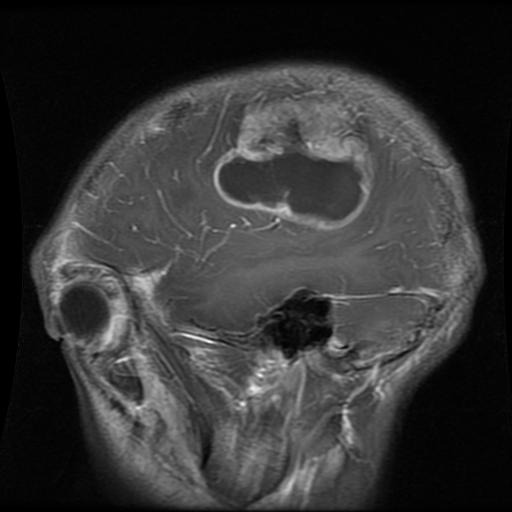

In [ ]:
example['image']

In [ ]:
dataset["Training"].features["label"]

ClassLabel(names=['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'], id=None)

In [ ]:
labels = dataset["Training"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

'no_tumor'

# PreProcessing

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
# split up training into training + validation
splits = dataset["Training"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 1,
 'pixel_values': tensor([[[-2.1008, -2.0837, -2.0837,  ..., -2.0665, -2.0665, -2.0665],
          [-2.1179, -2.0837, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-2.1179, -2.0837, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.0665, -2.0665],
          [-2.1008, -2.1179, -2.1179,  ..., -2.0665, -2.0665, -2.0665],
          [-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.0665, -2.0665]],
 
         [[-2.0182, -2.0007, -2.0007,  ..., -1.9832, -1.9832, -1.9832],
          [-2.0357, -2.0007, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          [-2.0357, -2.0007, -1.9832,  ..., -1.9832, -1.9832, -1.9832],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -1.9832, -1.9832],
          [-2.0182, -2.0357, -2.0357,  ..., -1.9832, -1.9832, -1.9832],
          [-2.0357, -2.0357, -2.0357,  ..., -1.9832, -1.9832, -1.9832]]

# Training the Model

In [ ]:
labels = dataset["Training"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-brain-tumour-classification",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.843400,0.640927,0.759582
1,0.500800,0.383029,0.874564


Epoch,Training Loss,Validation Loss,Accuracy
0,0.843400,0.640927,0.759582
1,0.500800,0.383029,0.874564
2,0.412500,0.334251,0.891986


***** train metrics *****
  epoch                    =        2.96
  total_flos               = 177377118GF
  train_loss               =      0.6758
  train_runtime            =  1:41:28.05
  train_samples_per_second =       1.273
  train_steps_per_second   =        0.01


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.96
  eval_accuracy           =      0.892
  eval_loss               =     0.3343
  eval_runtime            = 0:01:09.81
  eval_samples_per_second =      4.111
  eval_steps_per_second   =      0.129


## Interference

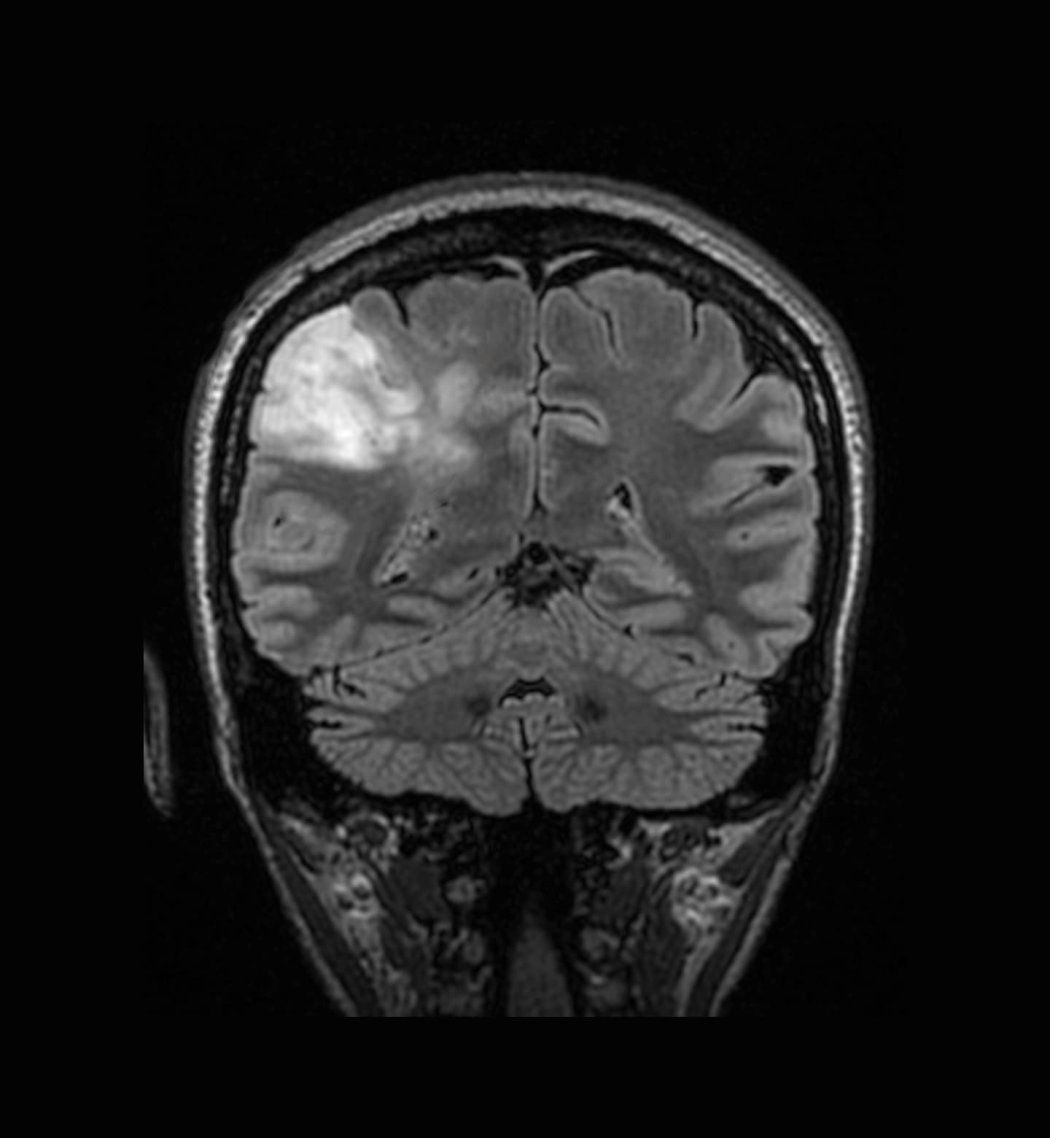

In [ ]:
from PIL import Image
import requests

url = 'https://www.ucsf.edu/sites/default/files/styles/two_col_banner_medium/public/2023-01/oligodendroglioma-banner.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "elliotwork/swin-tiny-patch4-window7-224_brain_tumour_v4_accuracy_0.892"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [ ]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

In [ ]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
!zip -r /content/my_model


In [ ]:
from google.colab import files
files.download("/content/my_model")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
trainer.save_model("./my_model")

In [ ]:
# Assuming you have already loaded the model
model_name = 'elliotwork/swin-tiny-patch4-window7-224_brain_tumour_v4_accuracy_0.892'
model = AutoModelForImageClassification.from_pretrained(model_name)

# Store the repository name
repo_name = model_name.split('/')[0]
print(repo_name)

## Pipeline API

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("image-classification", model="elliotwork/swin-tiny-patch4-window7-224_brain_tumour_v4_accuracy_0.892")

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/110M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

In [ ]:
pipe(image)

[{'label': 'glioma_tumor', 'score': 0.4630470275878906},
 {'label': 'meningioma_tumor', 'score': 0.4465157985687256},
 {'label': 'no_tumor', 'score': 0.07928445190191269},
 {'label': 'pituitary_tumor', 'score': 0.011152724735438824}]

In [ ]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=image_processor)

In [ ]:
pipe(image)

[{'label': 'glioma_tumor', 'score': 0.4630470275878906},
 {'label': 'meningioma_tumor', 'score': 0.4465157985687256},
 {'label': 'no_tumor', 'score': 0.07928445190191269},
 {'label': 'pituitary_tumor', 'score': 0.011152724735438824}]